# SOLUTION: Linear Regression with Statsmodels for Movie Revenue- Part 2

- 05/10/22

## Activity: Create a Linear Regression Model with Statsmodels for Revenue

- Last Class:
    - We started working with JUST the data data from the TMDB API for years 2000-2021. 
    - We prepared the data for modeling
        - Some feature engineering
        - Our usual Preprocessing
        - New steps for statsmodels!
    - We fit a statsmodels linear regression.
    
    
- Today:
    - We Will inspect the model summary.
    - We will create the visualizations to check assumptions about the residuals.
    - We will iterate upon our model until we meet the 4 assumptions as best we can.
    - We will discuss tactics for dealing with violations of the assumptions. 
    - We will use our coefficients to make stakeholder recommendations (if theres time 🤞).

> **[🕹 Click here to jump to Part 2!](#🕹-Part-2:-Checking-Model-Assumptions)**

# 📺 Previously, on...

## Loading the Data

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

In [2]:
pd.set_option('display.max_columns',100)

### 📚 Finding & Loading Batches of Files with `glob`

In [3]:
## Checking what data we already in our Data folder using os.listdir
import os
FOLDER = '../Data/'
file_list = sorted(os.listdir(FOLDER))
file_list

['combined_tmdb_data.csv.gz']

In [4]:
## Try loading in the first .csv.gz file from the list
# pd.read_csv(file_list[1])

> Why isn't it working?

In [5]:
# ## let's check the filepath 
# file_list[1]

In [6]:
# ## add the folder plus filename
# FOLDER+ file_list[1]

In [7]:
## try read csv with folder plus filename
# pd.read_csv(FOLDER+ file_list[1])

- Now we would do that in a loop, and only want to open .csv.gz.
- But there is a better way!
>- Introducing `glob`
    - Glob takes a filepath/query and will find every filename that matches the pattern provided.
    - We use asterisks as wildcards in our query.
    


In [8]:
# import glob
# ## Make a filepath query
# q = FOLDER+"*.csv.gz"
# print(q)

In [9]:
# # Use glob.glob to get COMPLETE filepaths
# file_list = glob.glob(q)
# file_list

In [10]:
# # Use glob.glob to get COMPLETE filepaths
# q = FOLDER+"final_*.csv.gz"
# print(q)
# file_list = sorted(glob.glob(q))
# file_list

> But where are the rest of the years?

In [11]:
# ## in a sub-folder
# os.listdir(FOLDER+'2010-2021')

- Recursive Searching with glob.
    - add a `**/` in the middle of your query to grab any matches from all subfolders. 

In [12]:
# # Use glob.glob to get COMPLETE filepaths
# q = FOLDER+"/**/final_*.csv.gz"
# print(q)
# file_list = sorted(glob.glob(q,recursive=True))
# file_list

In [13]:
# ## use a list comprehension to load in all files into 1 dataframe
# df = pd.concat([pd.read_csv(f) for f in file_list])
# df

- Dealing with ParserErrors with "possibly malformed files"

    - for a reason I do not fully understand yet, some of the files I downloaded error if I try to read them.
        - "ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.`
    - After some googling, the fix was to add `lineterminator='\n'` to pd.read_csv


In [14]:
# ## use a list comprehension to load in all files into 1 dataframe
# df = pd.concat([pd.read_csv(f,lineterminator='\n') for f in file_list])
# df

In [15]:
# # remove ids that are 0
# df = df.loc[ df['imdb_id']!='0']
# df

In [16]:
# df = df.reset_index(drop=True)
# df

In [17]:
## saving the combined csv to disk
# df.to_csv(FOLDER+'combined_tmdb_data.csv.gz',compression='gzip',index=False)

df = pd.read_csv(FOLDER+'combined_tmdb_data.csv.gz',lineterminator='\n')
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
1,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
2,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
3,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
4,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60126,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
60127,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60128,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


## Preprocessing

In [18]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', 'status',
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN
1,tt0326965,0.0,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13
2,tt0331312,0.0,NaN,0.0,[],0.600,[],2010-01-01,0.0,0.0,This Wretched Life,5.0,1.0,NaN
3,tt0393049,0.0,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",2010-05-20,0.0,98.0,Anderson's Cross,4.0,5.0,NaN
4,tt0398286,0.0,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2010-11-24,592461732.0,100.0,Tangled,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",2009-09-01,250000.0,77.0,Cold by Nature,0.0,0.0,PG-13
60126,tt7786614,0.0,NaN,0.0,[],0.600,[],2009-01-01,0.0,100.0,Tattoo,5.0,1.0,NaN
60127,tt8170758,0.0,NaN,0.0,[],0.600,[],2009-10-27,0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR
60128,tt9330112,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN


### Feature Engineering


- Collection: convert to boolean
- Genres: get just name and OHE
- Cleaning Certification
- Converting release date to year, month, and day.

#### belongs to collection

In [19]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

3738

In [20]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    56392
True      3738
Name: belongs_to_collection, dtype: int64

#### genre

In [21]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [22]:
## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')
df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,genres_list
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Family
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Animation
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Science Fiction
1,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,Thriller
1,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,Mystery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,Drama
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,Thriller
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,Mystery
60129,tt9556198,0.0,True,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 14, 'nam...",0.840,"[{'id': 64599, 'logo_path': None, 'name': 'SRS...",2009-08-15,0.0,80.0,Deep Sea Monster Raiga,7.7,3.0,NaN,Action


In [23]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()
unique_genres

array(['Family', 'Animation', 'Science Fiction', 'Thriller', 'Mystery',
       'Drama', 'Romance', 'Comedy', 'War', 'Crime', 'Action',
       'Adventure', 'Horror', 'Fantasy', 'History', 'Western', 'Music',
       'Documentary', 'TV Movie'], dtype=object)

In [24]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,genres_list,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,"[Family, Animation, Science Fiction]",True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,"[Thriller, Mystery, Drama]",False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0331312,0.0,False,0.0,[],0.600,[],2010-01-01,0.0,0.0,This Wretched Life,5.0,1.0,NaN,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0393049,0.0,False,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",2010-05-20,0.0,98.0,Anderson's Cross,4.0,5.0,NaN,"[Romance, Comedy, Drama]",False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
4,tt0398286,0.0,False,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2010-11-24,592461732.0,100.0,Tangled,7.6,9364.0,PG,"[Animation, Family]",True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}]",0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",2009-09-01,250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,[Thriller],False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60126,tt7786614,0.0,False,0.0,[],0.600,[],2009-01-01,0.0,100.0,Tattoo,5.0,1.0,NaN,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60127,tt8170758,0.0,False,0.0,[],0.600,[],2009-10-27,0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,"[Drama, Thriller, Mystery]",False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [25]:
## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
0,tt0312305,0.0,False,0.0,2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0326965,0.0,False,0.0,6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0331312,0.0,False,0.0,0.600,[],2010-01-01,0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",2010-05-20,0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2010-11-24,592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",2009-09-01,250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60126,tt7786614,0.0,False,0.0,0.600,[],2009-01-01,0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60127,tt8170758,0.0,False,0.0,0.600,[],2009-10-27,0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60128,tt9330112,0.0,False,0.0,1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False


#### certification

In [26]:
## Checking Certification values
df['certification'].value_counts(dropna=False)

NaN                                45506
R                                   6097
NR                                  3261
PG-13                               3224
PG                                  1432
G                                    442
NC-17                                156
Unrated                                5
R                                      1
PG-13                                  1
10                                     1
-                                      1
UR                                     1
Not Rated                              1
ScreamFest Horror Film Festival        1
Name: certification, dtype: int64

In [27]:
# fix extra space certs
df['certification'] = df['certification'].str.strip()

In [28]:
## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

NaN      45507
R         6098
NR        3270
PG-13     3225
PG        1432
G          442
NC-17      156
Name: certification, dtype: int64

#### Converting year to sep features

In [29]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0312305,0.0,False,0.0,2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,tt0326965,0.0,False,0.0,6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,tt0331312,0.0,False,0.0,0.600,[],2010-01-01,0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",2010-05-20,0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2010-11-24,592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",2009-09-01,250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,tt7786614,0.0,False,0.0,0.600,[],2009-01-01,0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,tt8170758,0.0,False,0.0,0.600,[],2009-10-27,0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,tt9330112,0.0,False,0.0,1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


In [30]:
df[df['release_date'].isna()]

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
246,tt1160376,0.0,False,0.0,0.600,[],NaN,0.0,90.0,Unholy Reunion,2.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN
247,tt1161421,0.0,False,0.0,1.625,[],NaN,14500.0,100.0,Harvey Putter and the Ridiculous Premise,6.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN
279,tt1189267,0.0,False,0.0,0.620,[],NaN,0.0,0.0,Woodshop,5.0,1.0,NaN,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN
708,tt1381773,0.0,False,27000.0,0.600,[],NaN,0.0,119.0,A Genesis Found,5.3,2.0,NaN,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,NaN,NaN,NaN
1012,tt1482451,0.0,False,0.0,0.600,[],NaN,0.0,NaN,Florida Road,0.0,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60057,tt2130186,0.0,False,0.0,0.600,[],NaN,0.0,105.0,Running 4 President,0.0,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN
60081,tt2596914,0.0,False,95.0,0.623,[],NaN,0.0,0.0,Con la muerte en los 2 tacones,7.0,1.0,NaN,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,NaN,NaN,NaN
60084,tt2658190,0.0,False,0.0,0.600,[],NaN,0.0,0.0,"Mundaren Bira, Doan!",0.0,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN
60108,tt4572686,0.0,False,0.0,0.600,[],NaN,0.0,91.0,Vanguard,0.0,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN


In [31]:
## drop original feature
df = df.drop(columns=['release_date'])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60130 non-null  object 
 1   adult                  60130 non-null  float64
 2   belongs_to_collection  60130 non-null  bool   
 3   budget                 60130 non-null  float64
 4   popularity             60130 non-null  float64
 5   production_companies   60130 non-null  object 
 6   revenue                60130 non-null  float64
 7   runtime                59298 non-null  float64
 8   title                  60130 non-null  object 
 9   vote_average           60130 non-null  float64
 10  vote_count             60130 non-null  float64
 11  certification          14623 non-null  object 
 12  Genre_Family           60130 non-null  bool   
 13  Genre_Animation        60130 non-null  bool   
 14  Genre_Science Fiction  60130 non-null  bool   
 15  Ge

In [33]:
# df= df.drop(columns='Genre_nan')

## Train Test Split

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60130 non-null  object 
 1   adult                  60130 non-null  float64
 2   belongs_to_collection  60130 non-null  bool   
 3   budget                 60130 non-null  float64
 4   popularity             60130 non-null  float64
 5   production_companies   60130 non-null  object 
 6   revenue                60130 non-null  float64
 7   runtime                59298 non-null  float64
 8   title                  60130 non-null  object 
 9   vote_average           60130 non-null  float64
 10  vote_count             60130 non-null  float64
 11  certification          14623 non-null  object 
 12  Genre_Family           60130 non-null  bool   
 13  Genre_Animation        60130 non-null  bool   
 14  Genre_Science Fiction  60130 non-null  bool   
 15  Ge

In [35]:
df['production_companies']

0                                                       []
1                                                       []
2                                                       []
3        [{'id': 46102, 'logo_path': None, 'name': 'Ill...
4        [{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...
                               ...                        
60125    [{'id': 117146, 'logo_path': None, 'name': 'JE...
60126                                                   []
60127                                                   []
60128                                                   []
60129    [{'id': 64599, 'logo_path': None, 'name': 'SRS...
Name: production_companies, Length: 60130, dtype: object

In [36]:
drop_for_model = ['title','imdb_id','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,0.0,False,0.0,2.769,0.0,45.0,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,0.0,False,0.0,6.120,0.0,90.0,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,0.0,False,0.0,0.600,0.0,0.0,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,0.0,False,300000.0,2.418,0.0,98.0,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,0.0,False,260000000.0,119.168,592461732.0,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,0.0,False,0.0,0.600,250000.0,77.0,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,0.0,False,0.0,0.600,0.0,100.0,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,0.0,False,0.0,0.600,0.0,61.0,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,0.0,False,0.0,1.201,0.0,145.0,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  60130 non-null  float64
 1   belongs_to_collection  60130 non-null  bool   
 2   budget                 60130 non-null  float64
 3   popularity             60130 non-null  float64
 4   revenue                60130 non-null  float64
 5   runtime                59298 non-null  float64
 6   vote_average           60130 non-null  float64
 7   vote_count             60130 non-null  float64
 8   certification          14623 non-null  object 
 9   Genre_Family           60130 non-null  bool   
 10  Genre_Animation        60130 non-null  bool   
 11  Genre_Science Fiction  60130 non-null  bool   
 12  Genre_Thriller         60130 non-null  bool   
 13  Genre_Mystery          60130 non-null  bool   
 14  Genre_Drama            60130 non-null  bool   
 15  Ge

In [38]:
## Make x and y variables
y = df['revenue'].copy()
X = df.drop(columns=['revenue']).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
X_train.head()

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
9538,0.0,False,0.0,1.113,80.0,5.3,5.0,NaN,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,2013.0,10.0,1.0
16553,0.0,False,0.0,1.875,92.0,6.0,2.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2015.0,4.0,15.0
34106,0.0,False,0.0,1.499,101.0,2.0,1.0,R,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2020.0,11.0,4.0
3804,0.0,False,0.0,1.506,100.0,7.7,3.0,PG,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,2011.0,9.0,24.0
37747,0.0,False,300000.0,0.600,138.0,5.0,2.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2020.0,9.0,18.0


In [39]:
X_train.isna().sum()

adult                        0
belongs_to_collection        0
budget                       0
popularity                   0
runtime                    638
vote_average                 0
vote_count                   0
certification            34082
Genre_Family                 0
Genre_Animation              0
Genre_Science Fiction        0
Genre_Thriller               0
Genre_Mystery                0
Genre_Drama                  0
Genre_Romance                0
Genre_Comedy                 0
Genre_War                    0
Genre_Crime                  0
Genre_Action                 0
Genre_Adventure              0
Genre_Horror                 0
Genre_Fantasy                0
Genre_History                0
Genre_Western                0
Genre_Music                  0
Genre_Documentary            0
Genre_TV Movie               0
year                       792
month                      792
day                        792
dtype: int64

In [40]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification']

In [41]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['adult',
 'budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day']

In [42]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

['belongs_to_collection',
 'Genre_Family',
 'Genre_Animation',
 'Genre_Science Fiction',
 'Genre_Thriller',
 'Genre_Mystery',
 'Genre_Drama',
 'Genre_Romance',
 'Genre_Comedy',
 'Genre_War',
 'Genre_Crime',
 'Genre_Action',
 'Genre_Adventure',
 'Genre_Horror',
 'Genre_Fantasy',
 'Genre_History',
 'Genre_Western',
 'Genre_Music',
 'Genre_Documentary',
 'Genre_TV Movie']

In [43]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [44]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((num_pipe, num_cols),
                                       (cat_pipe,cat_cols),remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count', 'year', 'month',
                                  'day']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification'])])

In [45]:
## fit the col transformer
preprocessor.fit(X_train)

## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-2']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [46]:
## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


## Create the empty list
final_features = [*num_cols,*cat_features,*already_ohe_cols]
len(final_features)

36

In [47]:
preprocessor.transform(X_train).shape

(45097, 36)

In [48]:
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_tf.head()


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
9538,0.0,0.0,1.113,80.0,5.3,5.0,2013.0,10.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16553,0.0,0.0,1.875,92.0,6.0,2.0,2015.0,4.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34106,0.0,0.0,1.499,101.0,2.0,1.0,2020.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3804,0.0,0.0,1.506,100.0,7.7,3.0,2011.0,9.0,24.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37747,0.0,300000.0,0.600,138.0,5.0,2.0,2020.0,9.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                         columns=final_features, index=X_test.index)
X_test_tf.head()

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
19252,0.0,1000.0,1.422,70.0,0.0,0.0,2015.0,12.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40663,0.0,0.0,3.180,99.0,7.0,4.0,2021.0,11.0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35595,0.0,0.0,3.285,0.0,6.4,16.0,2019.0,8.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
979,0.0,0.0,1.052,90.0,5.0,4.0,2010.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44055,0.0,26000000.0,16.946,126.0,7.4,1011.0,2021.0,2.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Adding a Constant for Statsmodels

In [50]:
##import statsmodels correctly
import statsmodels.api as sm

> Tip: make sure that add_constant actually added a new column! You may need to change the parameter `has_constant` to "add"

In [51]:
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
display(X_train_df.head(2),X_test_df.head(2))

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,const
9538,0.0,0.0,1.113,80.0,5.3,5.0,2013.0,10.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16553,0.0,0.0,1.875,92.0,6.0,2.0,2015.0,4.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,const
19252,0.0,1000.0,1.422,70.0,0.0,0.0,2015.0,12.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40663,0.0,0.0,3.180,99.0,7.0,4.0,2021.0,11.0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 🕹 Part 2: Checking Model Assumptions

## Modeling

### Statsmodels OLS

In [52]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3972.
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:16:46   Log-Likelihood:            -8.4213e+05
No. Observations:               45097   AIC:                         1.684e+06
Df Residuals:                   45061   BIC:                         1.685e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
adult                  1.371e+06   3.64e+06      0.376      0.707   -5.77e+06    8.51e+06
budget                    1.5448      0.014    110.732      0.000       1.517       1.572
popularity             1.419e+05   4441.421     31.954      0.000    1.33e+05    1.51e+05
runtime               -6249.4768   5192.945     -1.203      0.229   -1.64e+04    3928.782
vote_average          -4.954e+05   6.07e+04     -8.155      0.000   -6.14e+05   -3.76e+05
vote_count             2.895e+04    198.629    145.762      0.000    2.86e+04    2.93e+04
year                    2.57e+04   2.64e+04      0.972      0.331   -2.61e+04    7.75e+04
month                 -8.267e+04    4.2e+04     -1.968      0.049   -1.65e+05    -335.885
day                   -1.436e+04   1.62e+04     -0.886      0.376   -4.61e+04    1.74e+04
certification_G       -5.295e+06   6.82e+06     -0.776      0.438   -1.87e+07    8.08e+06
certification_MISSING -2.089e+06    6.7e+06     -0.312      0.755   -1.52e+07     1.1e+07
certification_NC-17   -6.958e+06   7.13e+06     -0.976      0.329   -2.09e+07    7.01e+06
certification_NR       -3.31e+06   6.72e+06     -0.492      0.622   -1.65e+07    9.87e+06
certification_PG      -1.681e+06    6.7e+06     -0.251      0.802   -1.48e+07    1.15e+07
certification_PG-13   -1.082e+07   6.67e+06     -1.623      0.105   -2.39e+07    2.25e+06
certification_R       -1.659e+07   6.64e+06     -2.500      0.012   -2.96e+07   -3.58e+06
belongs_to_collection  1.158e+07   6.56e+05     17.642      0.000    1.03e+07    1.29e+07
Genre_Family           -1.38e+06   7.42e+05     -1.859      0.063   -2.83e+06    7.49e+04
Genre_Animation        4.821e+05    9.2e+05      0.524      0.600   -1.32e+06    2.29e+06
Genre_Science Fiction -5.211e+06   6.74e+05     -7.730      0.000   -6.53e+06   -3.89e+06
Genre_Thriller        -1.327e+06   4.29e+05     -3.095      0.002   -2.17e+06   -4.86e+05
Genre_Mystery         -2.097e+06   6.88e+05     -3.046      0.002   -3.45e+06   -7.48e+05
Genre_Drama           -3.558e+05   3.37e+05     -1.054      0.292   -1.02e+06    3.06e+05
Genre_Romance           2.86e+04   4.59e+05      0.062      0.950   -8.72e+05    9.29e+05
Genre_Comedy          -3.946e+05   3.62e+05     -1.091      0.275    -1.1e+06    3.14e+05
Genre_War             -1.922e+06   1.23e+06     -1.559      0.119   -4.34e+06    4.95e+05
Genre_Crime           -2.812e+06   5.87e+05     -4.792      0.000   -3.96e+06   -1.66e+06
Genre_Action          -1.452e+06   5.04e+05     -2.880      0.004   -2.44e+06   -4.64e+05
Genre_Adventure        2.352e+06   7.41e+05      3.174      0.002       9e+05    3.81e+06
Genre_Horror          -5.668e+04   4.57e+05     -0.124      0.901   -9.53e+05     8.4e+05
Genre_Fantasy         -1.223e+06   7.42e+05     -1.648      0.099   -2.68e+06    2.31e+05
Genre_History         -

In [53]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.755
Testing R^2: 0.756


# The Assumptions of Linear Regression

- The 4 Assumptions of a Linear Regression are:
    - Linearity: That the input features have a linear relationship with the target.
    - Independence of features (AKA Little-to-No Multicollinearity): That the features are not strongly related to other features.
    - **Normality: The model's residuals are approximately normally distributed.**
    - **Homoscedasticity: The model residuals have equal variance across all predictions.**


### QQ-Plot for Checking for Normality

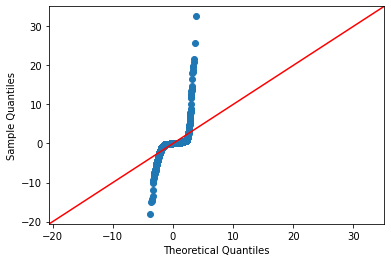

In [54]:
## Create a Q-QPlot

# first calculate residuals 
resid = y_test - y_hat_test

## then use sm's qqplot
fig, ax = plt.subplots(figsize=(6,4))
sm.graphics.qqplot(resid,line='45',fit=True,ax=ax);

### Residual Plot for Checking Homoscedasticity

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Predicted Revenue')]

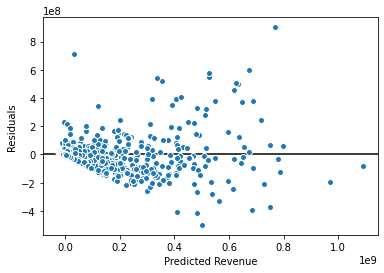

In [55]:
## Plot scatterplot with y_hat_test vs resids
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_hat_test, resid, ec='white')
ax.axhline(0,c='black',zorder=0)
ax.set(ylabel='Residuals',xlabel='Predicted Revenue')

### Putting it all together

In [56]:
def evaluate_ols(result,X_train_df, y_train, show_summary=True):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    try:
        display(result.summary())
    except:
        pass
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3972.
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:16:46   Log-Likelihood:            -8.4213e+05
No. Observations:               45097   AIC:                         1.684e+06
Df Residuals:                   45061   BIC:                         1.685e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
adult                  1.371e+06   3.64e+06      0.376      0.707   -5.77e+06    8.51e+06
budget                    1.5448      0.014    110.732      0.000       1.517       1.572
popularity             1.419e+05   4441.421     31.954      0.000    1.33e+05    1.51e+05
runtime               -6249.4768   5192.945     -1.203      0.229   -1.64e+04    3928.782
vote_average          -4.954e+05   6.07e+04     -8.155      0.000   -6.14e+05   -3.76e+05
vote_count             2.895e+04    198.629    145.762      0.000    2.86e+04    2.93e+04
year                    2.57e+04   2.64e+04      0.972      0.331   -2.61e+04    7.75e+04
month                 -8.267e+04    4.2e+04     -1.968      0.049   -1.65e+05    -335.885
day                   -1.436e+04   1.62e+04     -0.886      0.376   -4.61e+04    1.74e+04
certification_G       -5.295e+06   6.82e+06     -0.776      0.438   -1.87e+07    8.08e+06
certification_MISSING -2.089e+06    6.7e+06     -0.312      0.755   -1.52e+07     1.1e+07
certification_NC-17   -6.958e+06   7.13e+06     -0.976      0.329   -2.09e+07    7.01e+06
certification_NR       -3.31e+06   6.72e+06     -0.492      0.622   -1.65e+07    9.87e+06
certification_PG      -1.681e+06    6.7e+06     -0.251      0.802   -1.48e+07    1.15e+07
certification_PG-13   -1.082e+07   6.67e+06     -1.623      0.105   -2.39e+07    2.25e+06
certification_R       -1.659e+07   6.64e+06     -2.500      0.012   -2.96e+07   -3.58e+06
belongs_to_collection  1.158e+07   6.56e+05     17.642      0.000    1.03e+07    1.29e+07
Genre_Family           -1.38e+06   7.42e+05     -1.859      0.063   -2.83e+06    7.49e+04
Genre_Animation        4.821e+05    9.2e+05      0.524      0.600   -1.32e+06    2.29e+06
Genre_Science Fiction -5.211e+06   6.74e+05     -7.730      0.000   -6.53e+06   -3.89e+06
Genre_Thriller        -1.327e+06   4.29e+05     -3.095      0.002   -2.17e+06   -4.86e+05
Genre_Mystery         -2.097e+06   6.88e+05     -3.046      0.002   -3.45e+06   -7.48e+05
Genre_Drama           -3.558e+05   3.37e+05     -1.054      0.292   -1.02e+06    3.06e+05
Genre_Romance           2.86e+04   4.59e+05      0.062      0.950   -8.72e+05    9.29e+05
Genre_Comedy          -3.946e+05   3.62e+05     -1.091      0.275    -1.1e+06    3.14e+05
Genre_War             -1.922e+06   1.23e+06     -1.559      0.119   -4.34e+06    4.95e+05
Genre_Crime           -2.812e+06   5.87e+05     -4.792      0.000   -3.96e+06   -1.66e+06
Genre_Action          -1.452e+06   5.04e+05     -2.880      0.004   -2.44e+06   -4.64e+05
Genre_Adventure        2.352e+06   7.41e+05      3.174      0.002       9e+05    3.81e+06
Genre_Horror          -5.668e+04   4.57e+05     -0.124      0.901   -9.53e+05     8.4e+05
Genre_Fantasy         -1.223e+06   7.42e+05     -1.648      0.099   -2.68e+06    2.31e+05
Genre_History         -

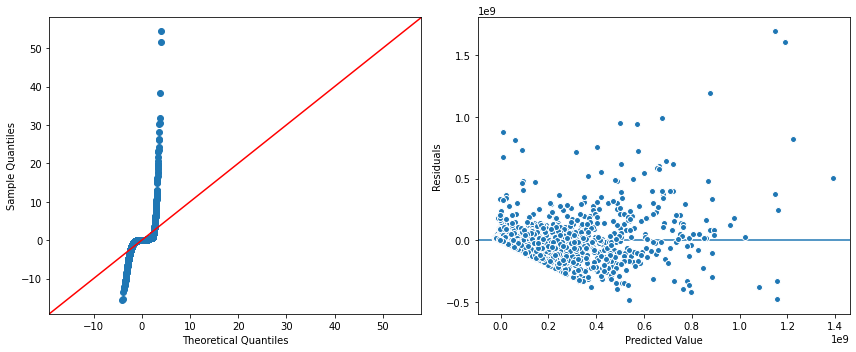

In [57]:
evaluate_ols(result,X_train_df, y_train)

# Improving Our Model:

> "Garbage In = Garbage Out"


- Before we dive into iterating on our model, I realized there were some big issues that I did not account for in the original data. 
    - some movies may not have been released. 
    - We should probably remove movies with 0 budget and revenue.
    

In [58]:
## reload the data
df = pd.read_csv(FOLDER+'combined_tmdb_data.csv.gz',lineterminator='\n')
df.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
1,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13


### Repeating Feature Engineering

In [59]:
## Columns to exclude - Keeping Status and companies
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', #'status','production_companies'
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)

## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()

## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')

## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    


## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])


#### Fixing Certification
## Checking Certification values
df['certification'].value_counts(dropna=False)
# fix extra space certs
df['certification'] = df['certification'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)


#### Converting year to sep features
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

## drop original feature
df = df.drop(columns=['release_date'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Released,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,Released,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,Released,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Released,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Released,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Released,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Released,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,Released,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,tt9330112,0.0,False,0.0,1.201,[],0.0,145.0,Released,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


### Filtering

- Make sure to only keep:
    1. Status=Released.
    2. Budget >0
    3. Revenue >0

In [60]:
## Check status
df['status'].value_counts()

Released           60097
Post Production       27
In Production          6
Name: status, dtype: int64

In [61]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,tt9330112,0.0,False,0.0,1.201,[],0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


In [62]:
## filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",5.924617e+08,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
6,tt0411951,0.0,True,30000000.0,70.694,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...",9.670000e+05,92.0,Tekken,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
9,tt0427152,0.0,False,69000000.0,21.747,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...",8.638786e+07,114.0,Dinner for Schmucks,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
10,tt0429493,0.0,False,110000000.0,56.494,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...",1.772388e+08,117.0,The A-Team,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
11,tt0435761,0.0,True,200000000.0,93.983,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...",1.066970e+09,103.0,Toy Story 3,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59859,tt1532382,0.0,True,3500000.0,4.838,[],3.704408e+06,97.0,Hooked on the Game,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
59887,tt1542960,0.0,False,300000.0,1.937,"[{'id': 46722, 'logo_path': None, 'name': 'Gol...",2.000000e+05,122.0,The Figurine (Araromire),4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
59923,tt1560950,0.0,True,600.0,1.795,[],3.000000e+00,81.0,D@bbe 2,1.9,10.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,12.0,24.0
59929,tt1565058,0.0,True,125000.0,5.989,"[{'id': 4580, 'logo_path': None, 'name': 'Cine...",3.470000e+06,88.0,A Blood Pledge,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,6.0,18.0


In [63]:
drop_for_model = ['title','imdb_id','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
4,0.0,False,260000000.0,119.168,5.924617e+08,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
6,0.0,True,30000000.0,70.694,9.670000e+05,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
9,0.0,False,69000000.0,21.747,8.638786e+07,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
10,0.0,False,110000000.0,56.494,1.772388e+08,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
11,0.0,True,200000000.0,93.983,1.066970e+09,103.0,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59859,0.0,True,3500000.0,4.838,3.704408e+06,97.0,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
59887,0.0,False,300000.0,1.937,2.000000e+05,122.0,4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
59923,0.0,True,600.0,1.795,3.000000e+00,81.0,1.9,10.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,12.0,24.0
59929,0.0,True,125000.0,5.989,3.470000e+06,88.0,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,6.0,18.0


# Checking for Linearity

In [64]:
## concatenating training data into plot_df
plot_df = pd.concat([X_train_df,y_train],axis=1)
plot_df

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,const,revenue
9538,0.0,0.0,1.113,80.0,5.3,5.0,2013.0,10.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16553,0.0,0.0,1.875,92.0,6.0,2.0,2015.0,4.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34106,0.0,0.0,1.499,101.0,2.0,1.0,2020.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3804,0.0,0.0,1.506,100.0,7.7,3.0,2011.0,9.0,24.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
37747,0.0,300000.0,0.600,138.0,5.0,2.0,2020.0,9.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5929,0.0,0.0,1.400,95.0,5.0,4.0,2012.0,10.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
43807,0.0,100000.0,1.660,82.0,4.8,4.0,2021.0,2.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4220,0.0,0.0,0.843,92.0,0.0,0.0,2011.0,10.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6682,0.0,0.0,3.976,113.0,6.0,18.0,2012.0,6.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
## save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in df.columns if c.startswith('Genre')]
plot_cols = plot_df.drop(columns=['revenue',*genre_cols]).columns
len(plot_cols)

18

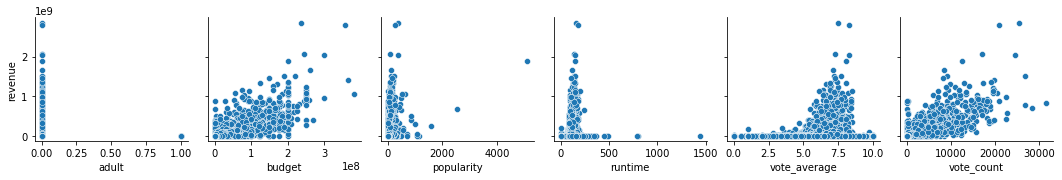

In [66]:
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[:6])

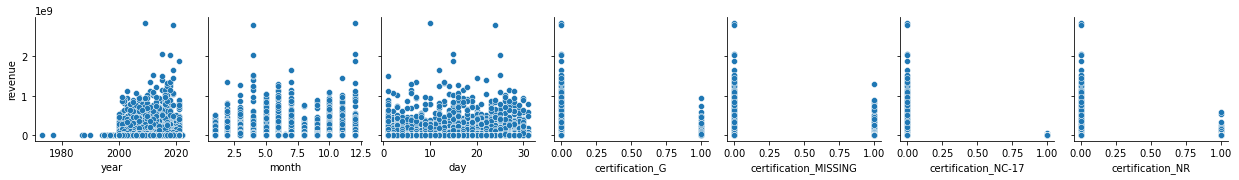

In [67]:
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[6:13])

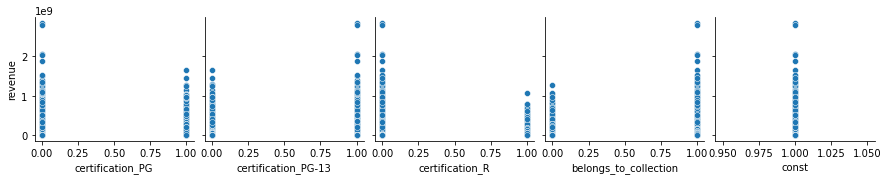

In [68]:
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[13:])

- Shouldn't have years before 2000, so drop. 
- Check outliers in popularity, runtime


In [69]:
# remove movies prior to 2000
df = df.loc[ df['year']>=2000]
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
4,0.0,False,260000000.0,119.168,5.924617e+08,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
6,0.0,True,30000000.0,70.694,9.670000e+05,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
9,0.0,False,69000000.0,21.747,8.638786e+07,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
10,0.0,False,110000000.0,56.494,1.772388e+08,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
11,0.0,True,200000000.0,93.983,1.066970e+09,103.0,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59859,0.0,True,3500000.0,4.838,3.704408e+06,97.0,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
59887,0.0,False,300000.0,1.937,2.000000e+05,122.0,4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
59923,0.0,True,600.0,1.795,3.000000e+00,81.0,1.9,10.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,12.0,24.0
59929,0.0,True,125000.0,5.989,3.470000e+06,88.0,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,6.0,18.0


> Now need to recreate X and y varaibles

In [70]:
def get_train_test_split(df_, y_col='revenue',drop_cols=[]):
    
    ## Make copy of input df
    df = df_.copy()
    
    ## filter columns in drop cols (if exist)
    final_drop_cols = []
    [df.drop(columns=c,inplace=True) for c in df.columns if c in drop_cols]
    
    
    ## Make x and y variables
    y = df[y_col].copy()
    X = df.drop(columns=[y_col]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
    

    
    ## make cat selector and using it to save list of column names
    cat_select = make_column_selector(dtype_include='object')
    cat_cols = cat_select(X_train)


    ## make num selector and using it to save list of column names
    num_select = make_column_selector(dtype_include='number')
    num_cols = num_select(X_train)


    ## select manually OHE cols for later
    bool_select = make_column_selector(dtype_include='bool')
    already_ohe_cols = bool_select(X_train)

    ## convert manual ohe to int
    X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
    X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

    ## make pipelines
    cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                             OneHotEncoder(handle_unknown='ignore', sparse=False))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                            )

    preprocessor = make_column_transformer((num_pipe, num_cols),
                                           (cat_pipe,cat_cols),remainder='passthrough')
    
    

    ## fit the col transformer
    preprocessor.fit(X_train)

    ## Finding the categorical pipeline in our col transformer.
    preprocessor.named_transformers_['pipeline-2']

    ## B) Using list-slicing to find the encoder 
    cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


    ## Create the empty list
    final_features = [*cat_features,*num_cols,*already_ohe_cols]

    ## Make df verisons of x data
    X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


    X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)


    ### Adding a Constant for Statsmodels
    ## Make final X_train_df and X_test_df with constants added
    X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
    X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
    return X_train_df, y_train, X_test_df, y_test


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     358.5
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:16:48   Log-Likelihood:                -75285.
No. Observations:                3810   AIC:                         1.506e+05
Df Residuals:                    3776   BIC:                         1.508e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G          47.8387     26.374      1.814      0.070      -3.869      99.547
certification_MISSING     1.7725      0.054     32.683      0.000       1.666       1.879
certification_NC-17    2.748e+04   2.96e+04      0.928      0.353   -3.06e+04    8.55e+04
certification_NR       2.524e+05   8.63e+04      2.926      0.003    8.33e+04    4.22e+05
certification_PG      -3.459e+06   1.48e+06     -2.344      0.019   -6.35e+06   -5.66e+05
certification_PG-13    2.924e+04    683.744     42.763      0.000    2.79e+04    3.06e+04
certification_R        4.884e+05   2.77e+05      1.762      0.078   -5.49e+04    1.03e+06
adult                 -6.909e+05   4.41e+05     -1.566      0.117   -1.56e+06    1.74e+05
budget                  2.15e+05   1.76e+05      1.219      0.223   -1.31e+05    5.61e+05
popularity            -1.288e+08   6.99e+07     -1.844      0.065   -2.66e+08    8.15e+06
runtime               -1.153e+08   7.04e+07     -1.638      0.102   -2.53e+08    2.27e+07
vote_average          -1.313e+08   7.47e+07     -1.758      0.079   -2.78e+08    1.51e+07
vote_count            -1.196e+08   7.05e+07     -1.697      0.090   -2.58e+08    1.86e+07
year                  -1.171e+08   6.98e+07     -1.678      0.093   -2.54e+08    1.97e+07
month                 -1.302e+08   6.96e+07     -1.870      0.062   -2.67e+08     6.3e+06
day                   -1.432e+08   6.97e+07     -2.055      0.040    -2.8e+08   -6.56e+06
belongs_to_collection  5.245e+07   4.07e+06     12.891      0.000    4.45e+07    6.04e+07
Genre_Family          -1.074e+07   7.67e+06     -1.401      0.161   -2.58e+07    4.29e+06
Genre_Animation        2.833e+07   8.24e+06      3.440      0.001    1.22e+07    4.45e+07
Genre_Science Fiction -3.486e+07   5.68e+06     -6.131      0.000    -4.6e+07   -2.37e+07
Genre_Thriller        -3.908e+06   4.16e+06     -0.939      0.348   -1.21e+07    4.25e+06
Genre_Mystery         -1.134e+07    5.8e+06     -1.954      0.051   -2.27e+07    3.73e+04
Genre_Drama            5.142e+05   3.92e+06      0.131      0.896   -7.16e+06    8.19e+06
Genre_Romance          6.933e+06   4.35e+06      1.595      0.111   -1.59e+06    1.55e+07
Genre_Comedy           2.291e+06    3.9e+06      0.587      0.557   -5.36e+06    9.95e+06
Genre_War              3.682e+06   8.73e+06      0.422      0.673   -1.34e+07    2.08e+07
Genre_Crime           -6.791e+06   4.82e+06     -1.408      0.159   -1.62e+07    2.66e+06
Genre_Action          -8.985e+06   4.21e+06     -2.137      0.033   -1.72e+07   -7.41e+05
Genre_Adventure        9.081e+06   5.06e+06      1.794      0.073   -8.41e+05     1.9e+07
Genre_Horror           4.442e+06   5.62e+06      0.790      0.430   -6.58e+06    1.55e+07
Genre_Fantasy         -1.143e+07   5.43e+06     -2.106      0.035   -2.21e+07   -7.91e+05
Genre_History         -

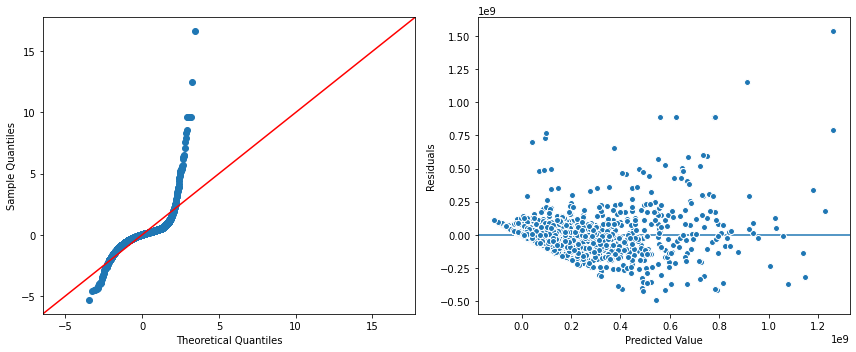

In [71]:
## Use our function to make new x,y vars
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df)

## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
evaluate_ols(result,X_train_df,y_train)

## Removing Outliers

In [72]:
from scipy import stats
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

In [73]:
from sklearn.compose import make_column_selector

In [74]:
num_sel = make_column_selector(dtype_include='float')
num_cols = num_sel(df)
num_cols

['adult',
 'budget',
 'popularity',
 'revenue',
 'runtime',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day']

In [75]:
## save a dictionary of the T/F outlier index for each feature in outleir_cols
outlier_cols = num_cols#['runtime','popularity','revenue']

outliers = {}
for col in outlier_cols:
    outliers_col = find_outliers(df[col])
    outliers[col] = outliers_col

- 1 outliers found in adult using Z-Scores.
- 141 outliers found in budget using Z-Scores.
- 34 outliers found in popularity using Z-Scores.
- 128 outliers found in revenue using Z-Scores.
- 0 outliers found in runtime using Z-Scores.
- 96 outliers found in vote_average using Z-Scores.
- 132 outliers found in vote_count using Z-Scores.
- 0 outliers found in year using Z-Scores.
- 0 outliers found in month using Z-Scores.
- 0 outliers found in day using Z-Scores.


In [76]:
# Make new df_clean copy of df
df_clean = df.copy()

## loop through dictionary to remove outliers
for col, idx_outliers in outliers.items():
    df_clean = df_clean[~idx_outliers]
df_clean

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_7980/1890287056.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[~idx_outliers]


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
6,0.0,True,30000000.0,70.694,967000.0,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
9,0.0,False,69000000.0,21.747,86387857.0,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
10,0.0,False,110000000.0,56.494,177238796.0,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
14,0.0,False,85000000.0,36.998,48000000.0,112.0,7.5,6331.0,PG-13,False,False,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,2010.0,8.0,12.0
17,0.0,False,20000000.0,19.663,54956140.0,101.0,6.2,1615.0,R,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,2010.0,2.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59698,0.0,False,31192.0,3.643,10000.0,89.0,6.3,54.0,NaN,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
59859,0.0,True,3500000.0,4.838,3704408.0,97.0,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
59887,0.0,False,300000.0,1.937,200000.0,122.0,4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
59929,0.0,True,125000.0,5.989,3470000.0,88.0,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,6.0,18.0


### Model 2: Outliers Removed (Z_scores)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     269.1
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:16:49   Log-Likelihood:                -67781.
No. Observations:                3531   AIC:                         1.356e+05
Df Residuals:                    3497   BIC:                         1.358e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G          -6.6486      3.154     -2.108      0.035     -12.832      -0.465
certification_MISSING     1.3577      0.041     33.181      0.000       1.277       1.438
certification_NC-17    1.255e+05   3.93e+04      3.193      0.001    4.85e+04    2.03e+05
certification_NR       9.516e+04   5.26e+04      1.809      0.071   -7994.751    1.98e+05
certification_PG       7.887e+04    1.3e+06      0.061      0.952   -2.47e+06    2.63e+06
certification_PG-13    2.275e+04    634.325     35.865      0.000    2.15e+04     2.4e+04
certification_R       -3.634e+05   1.68e+05     -2.162      0.031   -6.93e+05   -3.38e+04
adult                  3.396e+04   2.63e+05      0.129      0.897   -4.82e+05     5.5e+05
budget                  3.53e+04   1.04e+05      0.339      0.735   -1.69e+05     2.4e+05
popularity             1.003e+08   4.23e+07      2.371      0.018    1.73e+07    1.83e+08
runtime                9.083e+07   4.26e+07      2.131      0.033    7.25e+06    1.74e+08
vote_average           8.097e+07   4.44e+07      1.824      0.068   -6.06e+06    1.68e+08
vote_count             9.392e+07   4.28e+07      2.194      0.028       1e+07    1.78e+08
year                   1.002e+08   4.23e+07      2.366      0.018    1.72e+07    1.83e+08
month                  8.471e+07   4.22e+07      2.006      0.045    1.91e+06    1.67e+08
day                    7.181e+07   4.22e+07      1.700      0.089    -1.1e+07    1.55e+08
belongs_to_collection  3.566e+07   2.43e+06     14.664      0.000    3.09e+07    4.04e+07
Genre_Family          -7.019e+06   4.73e+06     -1.485      0.138   -1.63e+07    2.25e+06
Genre_Animation        1.118e+07   5.07e+06      2.208      0.027    1.25e+06    2.11e+07
Genre_Science Fiction -2.474e+07   3.45e+06     -7.175      0.000   -3.15e+07    -1.8e+07
Genre_Thriller        -2.107e+06   2.46e+06     -0.857      0.391   -6.92e+06    2.71e+06
Genre_Mystery         -1.118e+06   3.41e+06     -0.327      0.743   -7.81e+06    5.58e+06
Genre_Drama           -3.594e+06   2.34e+06     -1.534      0.125   -8.19e+06       1e+06
Genre_Romance          4.009e+06   2.54e+06      1.578      0.115   -9.73e+05    8.99e+06
Genre_Comedy           7.441e+06   2.33e+06      3.195      0.001    2.88e+06     1.2e+07
Genre_War             -2.579e+06   5.02e+06     -0.514      0.607   -1.24e+07    7.25e+06
Genre_Crime           -9.055e+06   2.77e+06     -3.274      0.001   -1.45e+07   -3.63e+06
Genre_Action           8.784e+05   2.47e+06      0.356      0.722   -3.97e+06    5.72e+06
Genre_Adventure       -3.785e+06      3e+06     -1.260      0.208   -9.67e+06     2.1e+06
Genre_Horror           3.113e+06   3.37e+06      0.923      0.356    -3.5e+06    9.73e+06
Genre_Fantasy         -8.875e+06   3.33e+06     -2.663      0.008   -1.54e+07   -2.34e+06
Genre_History         -

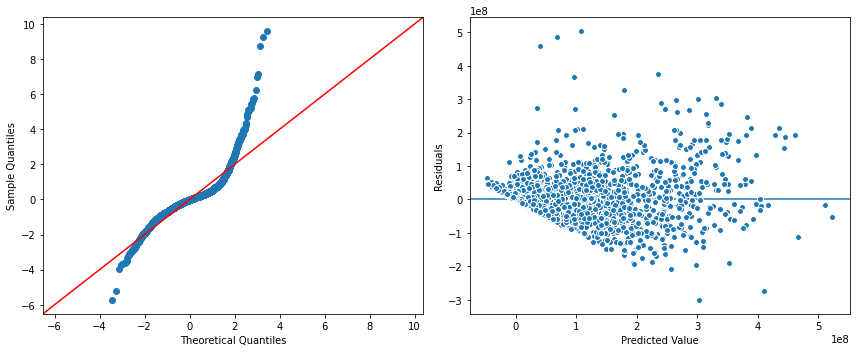

In [77]:
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean)
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
evaluate_ols(result,X_train_df,y_train)

### Removing Outliers - Using IQR Rule

<AxesSubplot:xlabel='revenue'>

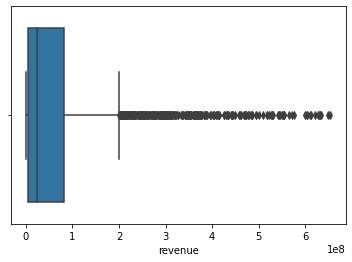

In [78]:
sns.boxplot(x = y_train)

In [79]:
def find_outliers_IQR(data, verbose=True):
    q3 = np.quantile(data,.75)
    q1 = np.quantile(data,.25)

    IQR = q3 - q1
    upper_threshold = q3 + 1.5*IQR
    lower_threshold = q1 - 1.5*IQR
    
    outliers = (data<lower_threshold) | (data>upper_threshold)
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using IQR.")
        
    return outliers

In [80]:
outliers_z = find_outliers(df['revenue'])
outliers_z

- 128 outliers found in revenue using Z-Scores.


4        False
6        False
9        False
10       False
11        True
         ...  
59859    False
59887    False
59923    False
59929    False
59937    False
Name: revenue, Length: 5081, dtype: bool

In [81]:
outliers_iqr = find_outliers_IQR(df['revenue'])
outliers_iqr

- 540 outliers found in revenue using IQR.


4         True
6        False
9        False
10       False
11        True
         ...  
59859    False
59887    False
59923    False
59929    False
59937    False
Name: revenue, Length: 5081, dtype: bool

In [82]:
## Loop to remove outliers from same clumns using new function
outlier_cols = num_cols#['runtime','popularity','revenue']

## Empty dict for both types of outliers
outliers_z = {}
outliers_iqr = {}

## Use both functions to see the comparison for # of outliers
for col in outlier_cols:
    outliers_col_z = find_outliers(df[col])
    outliers_z[col] = outliers_col_z
    
    outliers_col_iqr = find_outliers_IQR(df[col])
    outliers_iqr[col] = outliers_col_iqr
    print()
    

- 1 outliers found in adult using Z-Scores.
- 1 outliers found in adult using IQR.

- 141 outliers found in budget using Z-Scores.
- 466 outliers found in budget using IQR.

- 34 outliers found in popularity using Z-Scores.
- 518 outliers found in popularity using IQR.

- 128 outliers found in revenue using Z-Scores.
- 540 outliers found in revenue using IQR.

- 0 outliers found in runtime using Z-Scores.
- 0 outliers found in runtime using IQR.

- 96 outliers found in vote_average using Z-Scores.
- 148 outliers found in vote_average using IQR.

- 132 outliers found in vote_count using Z-Scores.
- 511 outliers found in vote_count using IQR.

- 0 outliers found in year using Z-Scores.
- 0 outliers found in year using IQR.

- 0 outliers found in month using Z-Scores.
- 0 outliers found in month using IQR.

- 0 outliers found in day using Z-Scores.
- 0 outliers found in day using IQR.



In [83]:
# remove_outliers 
df_clean_z = df.copy()
for col, idx_outliers in outliers_z.items():
    df_clean_z = df_clean_z[~idx_outliers]
df_clean_z

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_7980/3429278998.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_z = df_clean_z[~idx_outliers]


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
6,0.0,True,30000000.0,70.694,967000.0,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
9,0.0,False,69000000.0,21.747,86387857.0,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
10,0.0,False,110000000.0,56.494,177238796.0,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
14,0.0,False,85000000.0,36.998,48000000.0,112.0,7.5,6331.0,PG-13,False,False,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,2010.0,8.0,12.0
17,0.0,False,20000000.0,19.663,54956140.0,101.0,6.2,1615.0,R,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,2010.0,2.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59698,0.0,False,31192.0,3.643,10000.0,89.0,6.3,54.0,NaN,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
59859,0.0,True,3500000.0,4.838,3704408.0,97.0,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
59887,0.0,False,300000.0,1.937,200000.0,122.0,4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
59929,0.0,True,125000.0,5.989,3470000.0,88.0,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,6.0,18.0


In [84]:
# remove_outliers
df_clean_iqr = df.copy()
for col, idx_outliers in outliers_iqr.items():
    df_clean_iqr = df_clean_iqr[~idx_outliers]
df_clean_iqr

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_7980/739513175.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_iqr = df_clean_iqr[~idx_outliers]


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
9,0.0,False,69000000.0,21.747,86387857.0,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
17,0.0,False,20000000.0,19.663,54956140.0,101.0,6.2,1615.0,R,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,2010.0,2.0,26.0
22,0.0,True,24000000.0,48.675,83188165.0,88.0,5.4,1754.0,R,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,2010.0,8.0,20.0
30,0.0,False,25000000.0,56.909,23580000.0,97.0,6.3,1425.0,PG-13,False,False,False,True,True,False,False,False,False,True,True,True,False,False,False,False,False,False,False,2010.0,4.0,23.0
34,0.0,False,35000000.0,9.420,36236710.0,92.0,4.9,490.0,PG,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,2010.0,4.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59698,0.0,False,31192.0,3.643,10000.0,89.0,6.3,54.0,NaN,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
59859,0.0,True,3500000.0,4.838,3704408.0,97.0,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
59887,0.0,False,300000.0,1.937,200000.0,122.0,4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
59929,0.0,True,125000.0,5.989,3470000.0,88.0,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,6.0,18.0


### Model 3 - IQR Outliers Removed

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     151.5
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:16:51   Log-Likelihood:                -55127.
No. Observations:                2964   AIC:                         1.103e+05
Df Residuals:                    2930   BIC:                         1.105e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G          12.3660      2.548      4.853      0.000       7.369      17.363
certification_MISSING     0.9862      0.036     27.148      0.000       0.915       1.057
certification_NC-17    3.349e+05    6.6e+04      5.075      0.000    2.06e+05    4.64e+05
certification_NR       8.964e+04   3.04e+04      2.950      0.003    3.01e+04    1.49e+05
certification_PG       1.671e+06   8.41e+05      1.987      0.047    2.19e+04    3.32e+06
certification_PG-13    1.856e+04    697.954     26.597      0.000    1.72e+04    1.99e+04
certification_R       -5.096e+05   1.03e+05     -4.950      0.000   -7.11e+05   -3.08e+05
adult                 -8.346e+04   1.56e+05     -0.535      0.593   -3.89e+05    2.22e+05
budget                 2.117e+04   6.28e+04      0.337      0.736   -1.02e+05    1.44e+05
popularity             1.425e+08   2.59e+07      5.496      0.000    9.17e+07    1.93e+08
runtime                1.269e+08   2.61e+07      4.854      0.000    7.57e+07    1.78e+08
vote_average           1.143e+08   2.69e+07      4.246      0.000    6.15e+07    1.67e+08
vote_count             1.203e+08   2.61e+07      4.616      0.000    6.92e+07    1.71e+08
year                   1.329e+08   2.59e+07      5.129      0.000    8.21e+07    1.84e+08
month                  1.266e+08   2.59e+07      4.891      0.000    7.59e+07    1.77e+08
day                    1.142e+08   2.59e+07      4.414      0.000    6.35e+07    1.65e+08
belongs_to_collection  1.588e+07   1.56e+06     10.203      0.000    1.28e+07    1.89e+07
Genre_Family           2.056e+05   2.75e+06      0.075      0.940   -5.19e+06     5.6e+06
Genre_Animation        -3.98e+06   3.21e+06     -1.242      0.214   -1.03e+07    2.31e+06
Genre_Science Fiction -2.049e+07    2.3e+06     -8.890      0.000    -2.5e+07    -1.6e+07
Genre_Thriller        -2.872e+06   1.52e+06     -1.890      0.059   -5.85e+06    1.07e+05
Genre_Mystery          7.537e+04   2.11e+06      0.036      0.972   -4.07e+06    4.22e+06
Genre_Drama           -4.989e+06   1.41e+06     -3.537      0.000   -7.76e+06   -2.22e+06
Genre_Romance           1.17e+06   1.47e+06      0.795      0.426   -1.71e+06    4.05e+06
Genre_Comedy           4.585e+06   1.39e+06      3.305      0.001    1.87e+06     7.3e+06
Genre_War             -2.181e+06   3.11e+06     -0.700      0.484   -8.29e+06    3.93e+06
Genre_Crime           -1.998e+06   1.69e+06     -1.184      0.237   -5.31e+06    1.31e+06
Genre_Action           7.238e+05   1.54e+06      0.471      0.638   -2.29e+06    3.74e+06
Genre_Adventure       -3.959e+06   1.91e+06     -2.069      0.039   -7.71e+06   -2.07e+05
Genre_Horror           4.564e+06   2.06e+06      2.211      0.027    5.16e+05    8.61e+06
Genre_Fantasy         -8.342e+06   2.22e+06     -3.757      0.000   -1.27e+07   -3.99e+06
Genre_History          

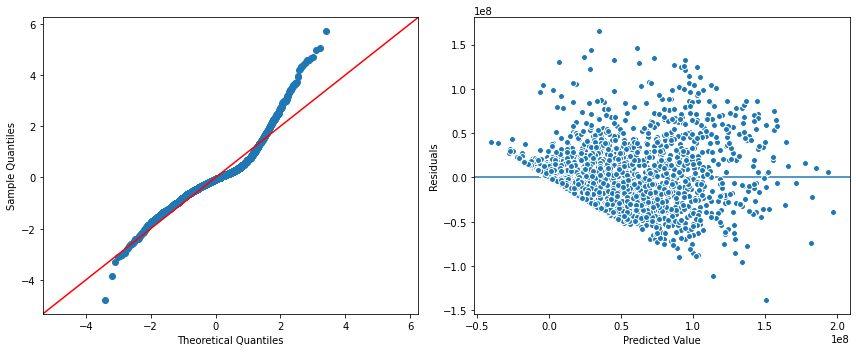

In [85]:
## MAKE NEW MODEL WITH IQR OUTLIERS REMOVED

X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_clean_iqr)
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
# display(result.summary())
evaluate_ols(result,X_train_df,y_train)

> How are we doing?

In [86]:
## get pvalues from model result
pvals = result.pvalues 
pvals

certification_G           1.282823e-06
certification_MISSING    5.705849e-145
certification_NC-17       4.125851e-07
certification_NR          3.202386e-03
certification_PG          4.704245e-02
certification_PG-13      8.482678e-140
certification_R           7.849081e-07
adult                     5.926254e-01
budget                    7.361914e-01
popularity                4.214676e-08
runtime                   1.272355e-06
vote_average              2.241498e-05
vote_count                4.082010e-06
year                      3.110407e-07
month                     1.059292e-06
day                       1.053453e-05
belongs_to_collection     4.816048e-24
Genre_Family              9.404347e-01
Genre_Animation           2.144807e-01
Genre_Science Fiction     1.043660e-18
Genre_Thriller            5.882591e-02
Genre_Mystery             9.715280e-01
Genre_Drama               4.110616e-04
Genre_Romance             4.264924e-01
Genre_Comedy              9.603951e-04
Genre_War                

In [87]:
## Check for p-values that are >.05
pvals[ pvals>.05]

adult                0.592625
budget               0.736191
Genre_Family         0.940435
Genre_Animation      0.214481
Genre_Thriller       0.058826
Genre_Mystery        0.971528
Genre_Romance        0.426492
Genre_War            0.483787
Genre_Crime          0.236630
Genre_Action         0.637789
Genre_History        0.858946
Genre_Music          0.116066
Genre_Documentary    0.784422
dtype: float64

## Removing features - based on p-values

In [88]:
## Get list of ALL genre columns to see how many are sig
genre_cols = [c for c in df_clean.columns if c.startswith("Genre")]
genre_cols

['Genre_Family',
 'Genre_Animation',
 'Genre_Science Fiction',
 'Genre_Thriller',
 'Genre_Mystery',
 'Genre_Drama',
 'Genre_Romance',
 'Genre_Comedy',
 'Genre_War',
 'Genre_Crime',
 'Genre_Action',
 'Genre_Adventure',
 'Genre_Horror',
 'Genre_Fantasy',
 'Genre_History',
 'Genre_Western',
 'Genre_Music',
 'Genre_Documentary',
 'Genre_TV Movie']

In [89]:
## save just genre pvalues
genre_pvals = pvals[genre_cols] 
genre_pvals.round(2)

Genre_Family             0.94
Genre_Animation          0.21
Genre_Science Fiction    0.00
Genre_Thriller           0.06
Genre_Mystery            0.97
Genre_Drama              0.00
Genre_Romance            0.43
Genre_Comedy             0.00
Genre_War                0.48
Genre_Crime              0.24
Genre_Action             0.64
Genre_Adventure          0.04
Genre_Horror             0.03
Genre_Fantasy            0.00
Genre_History            0.86
Genre_Western            0.00
Genre_Music              0.12
Genre_Documentary        0.78
Genre_TV Movie            NaN
dtype: float64

In [93]:
## calc what % are insig?
insig_genres = genre_pvals>.05
insig_genres.sum()/len(insig_genres)

0.5789473684210527

In [94]:
insig_genres

Genre_Family              True
Genre_Animation           True
Genre_Science Fiction    False
Genre_Thriller            True
Genre_Mystery             True
Genre_Drama              False
Genre_Romance             True
Genre_Comedy             False
Genre_War                 True
Genre_Crime               True
Genre_Action              True
Genre_Adventure          False
Genre_Horror             False
Genre_Fantasy            False
Genre_History             True
Genre_Western            False
Genre_Music               True
Genre_Documentary         True
Genre_TV Movie           False
dtype: bool

> both have <50% bad pvalues. Keep both!

In [95]:
## what pvals are remaining?
other_pvals = pvals.drop(genre_cols)
other_pvals[other_pvals>.05]

adult     0.592625
budget    0.736191
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     111.1
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:17:26   Log-Likelihood:                -55432.
No. Observations:                2964   AIC:                         1.109e+05
Df Residuals:                    2931   BIC:                         1.111e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G        5.965e+05   7.33e+04      8.135      0.000    4.53e+05     7.4e+05
certification_MISSING  2.421e+05   3.34e+04      7.243      0.000    1.77e+05    3.08e+05
certification_NC-17   -3.905e+06   9.16e+05     -4.263      0.000    -5.7e+06   -2.11e+06
certification_NR       2.559e+04    748.970     34.168      0.000    2.41e+04    2.71e+04
certification_PG      -1.071e+06   1.11e+05     -9.609      0.000   -1.29e+06   -8.52e+05
certification_PG-13    1.309e+05   1.72e+05      0.763      0.445   -2.06e+05    4.67e+05
certification_R        3.155e+04   6.93e+04      0.455      0.649   -1.04e+05    1.67e+05
popularity             2.802e+08   2.81e+07      9.975      0.000    2.25e+08    3.35e+08
runtime                2.657e+08   2.83e+07      9.385      0.000     2.1e+08    3.21e+08
vote_average           2.616e+08   2.93e+07      8.917      0.000    2.04e+08    3.19e+08
vote_count             2.607e+08   2.83e+07      9.218      0.000    2.05e+08    3.16e+08
year                   2.822e+08    2.8e+07     10.080      0.000    2.27e+08    3.37e+08
month                  2.769e+08   2.79e+07      9.910      0.000    2.22e+08    3.32e+08
day                    2.577e+08    2.8e+07      9.209      0.000    2.03e+08    3.13e+08
belongs_to_collection  1.235e+07    1.7e+06      7.251      0.000    9.01e+06    1.57e+07
Genre_Family           9.392e+06   3.06e+06      3.074      0.002     3.4e+06    1.54e+07
Genre_Animation        1.219e+06   3.51e+06      0.347      0.728   -5.66e+06     8.1e+06
Genre_Science Fiction -1.936e+07   2.52e+06     -7.673      0.000   -2.43e+07   -1.44e+07
Genre_Thriller         6.664e+05   1.66e+06      0.402      0.688   -2.59e+06    3.92e+06
Genre_Mystery         -8.262e+05   2.29e+06     -0.361      0.718   -5.32e+06    3.66e+06
Genre_Drama           -7.539e+06   1.57e+06     -4.813      0.000   -1.06e+07   -4.47e+06
Genre_Romance          4.442e+05   1.65e+06      0.270      0.787   -2.78e+06    3.67e+06
Genre_Comedy           7.155e+06   1.55e+06      4.618      0.000    4.12e+06    1.02e+07
Genre_War              7.272e+06   3.42e+06      2.126      0.034    5.66e+05     1.4e+07
Genre_Crime           -1.617e+06   1.83e+06     -0.886      0.376    -5.2e+06    1.96e+06
Genre_Action           3.669e+06   1.68e+06      2.181      0.029     3.7e+05    6.97e+06
Genre_Adventure        1.579e+05    2.1e+06      0.075      0.940   -3.96e+06    4.28e+06
Genre_Horror          -7.034e+06   2.26e+06     -3.108      0.002   -1.15e+07    -2.6e+06
Genre_Fantasy         -1.398e+06   2.47e+06     -0.565      0.572   -6.25e+06    3.45e+06
Genre_History          7.839e+06   2.83e+06      2.767      0.006    2.28e+06    1.34e+07
Genre_Western         -1.434e+07    6.3e+06     -2.276      0.023   -2.67e+07   -1.98e+06
Genre_Music            

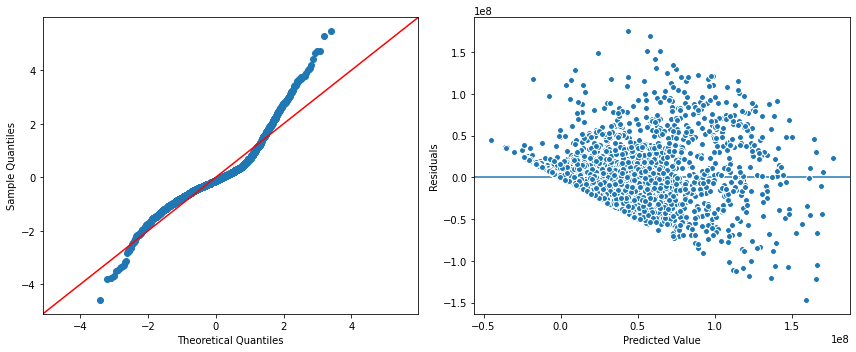

In [96]:
## Make x,y vars, but drop features with bad pvalues
df_clean_iqr = df_clean_iqr.drop(columns=['adult','budget'])
X_train_df, y_train, X_test_df, y_test = \
                                get_train_test_split(df_clean_iqr,)
## MAKE AND EVALUATE OLS
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
evaluate_ols(result,X_train_df,y_train)

# Addressing Multicollinearity

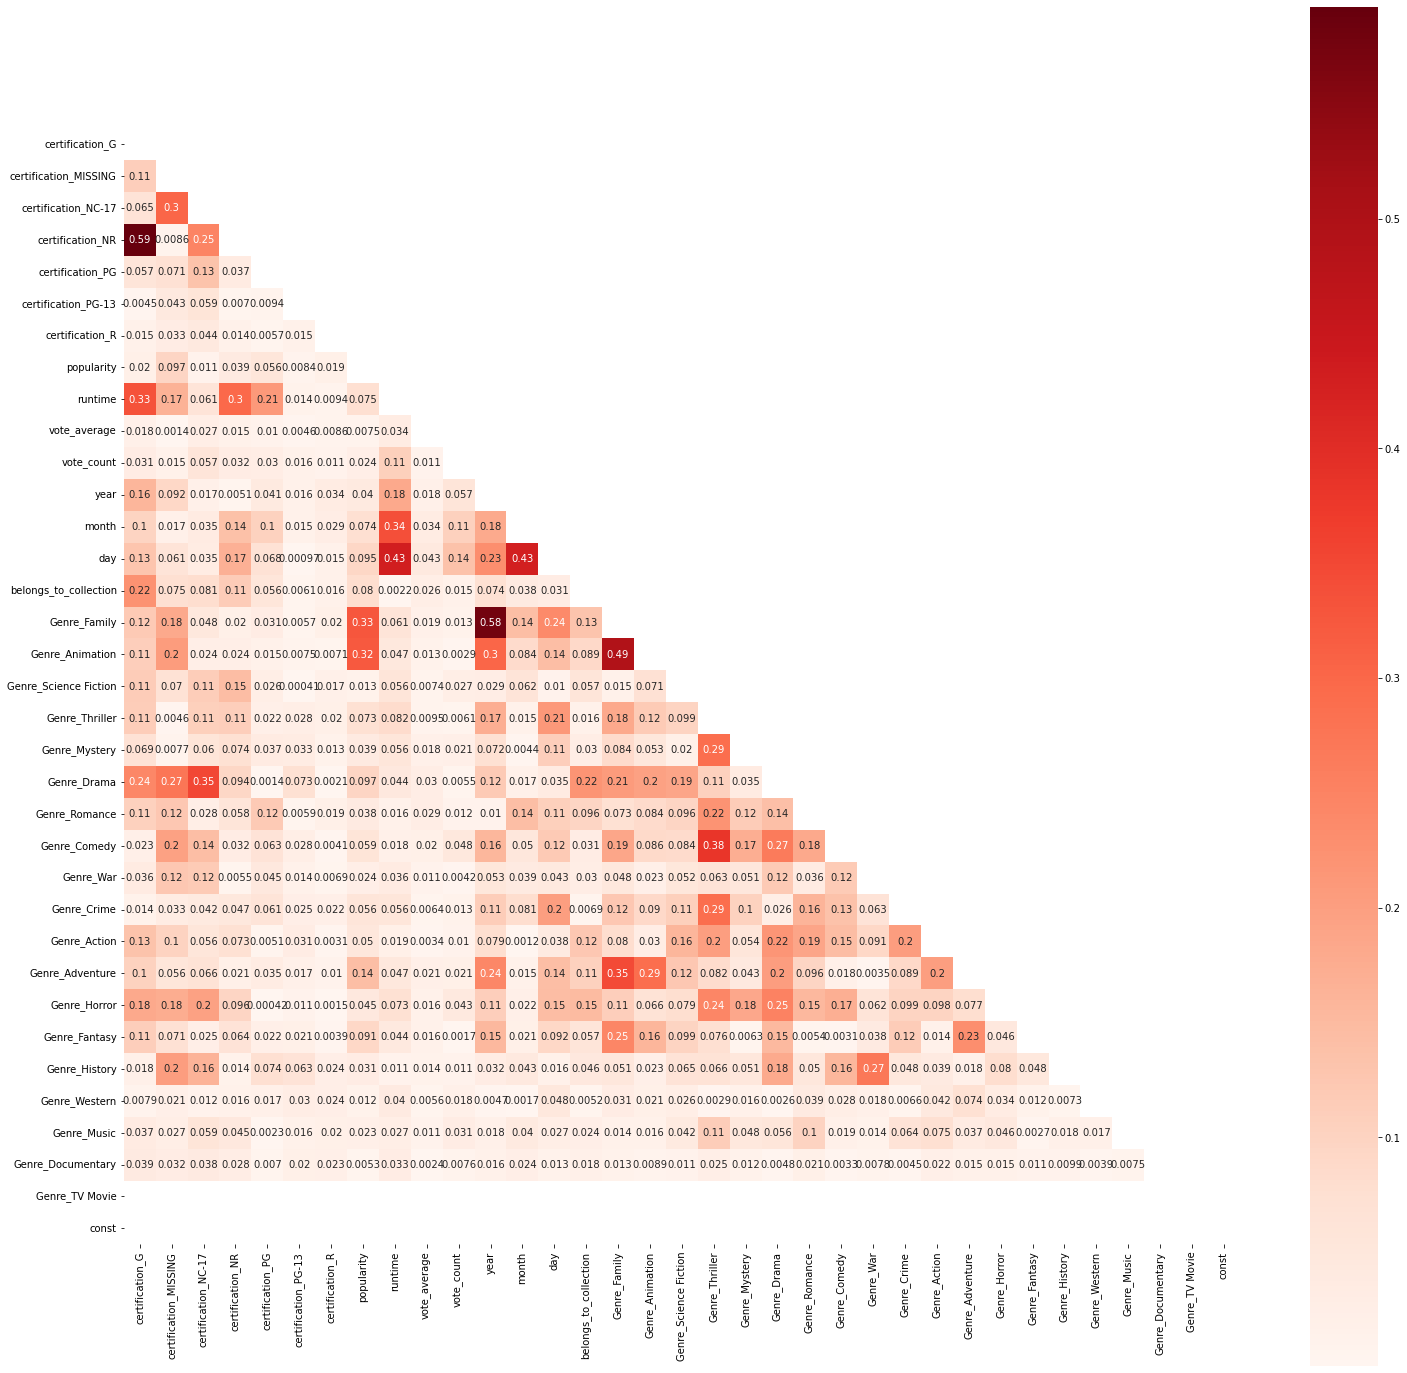

In [97]:
## Calculating the mask to hide the upper-right of the triangle
plt.figure(figsize=(25,25))
corr = X_train_df.corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);

## Variance Inflation Factor

In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
# separate just x-data and subtract mean
features = X_train_df -  X_train_df.mean()

features

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,const
51430,21.636937,-14.38664,-0.398178,1999.658232,-4.165992,-5.727395,-9.370445,-0.016194,-0.253711,-0.003374,-0.032726,-0.088057,-0.251687,0.645749,0.83502,-0.09278,-0.044534,-0.068151,-0.272605,-0.083671,-0.541835,-0.20108,-0.361673,-0.035088,-0.159919,-0.224359,-0.119096,0.888664,-0.069838,-0.054318,-0.009109,-0.032051,-0.001687,0.0,0.0
21175,6.037937,-18.38664,-0.498178,-632.341768,5.834008,-4.727395,-11.370445,-0.016194,-0.253711,-0.003374,-0.032726,0.911943,-0.251687,-0.354251,-0.16498,0.90722,0.955466,-0.068151,-0.272605,-0.083671,-0.541835,-0.20108,0.638327,-0.035088,-0.159919,-0.224359,0.880904,-0.111336,-0.069838,-0.054318,-0.009109,-0.032051,-0.001687,0.0,0.0
44355,1.005937,15.61336,-0.298178,-79.341768,-10.165992,5.272605,-7.370445,-0.016194,-0.253711,-0.003374,-0.032726,-0.088057,0.748313,-0.354251,-0.16498,-0.09278,-0.044534,-0.068151,0.727395,-0.083671,-0.541835,-0.20108,-0.361673,-0.035088,-0.159919,0.775641,0.880904,-0.111336,-0.069838,-0.054318,-0.009109,-0.032051,-0.001687,0.0,0.0
9072,-2.179063,19.61336,-0.298178,-59.341768,2.834008,3.272605,-4.370445,-0.016194,-0.253711,-0.003374,-0.032726,-0.088057,-0.251687,0.645749,-0.16498,-0.09278,-0.044534,-0.068151,0.727395,-0.083671,0.458165,-0.20108,-0.361673,-0.035088,-0.159919,-0.224359,-0.119096,-0.111336,-0.069838,-0.054318,-0.009109,-0.032051,-0.001687,0.0,0.0
58096,-3.564063,-2.38664,0.501822,750.658232,-1.165992,2.272605,14.629555,-0.016194,-0.253711,-0.003374,-0.032726,-0.088057,-0.251687,0.645749,-0.16498,-0.09278,-0.044534,-0.068151,-0.272605,-0.083671,0.458165,-0.20108,0.638327,-0.035088,-0.159919,-0.224359,-0.119096,-0.111336,-0.069838,-0.054318,-0.009109,-0.032051,-0.001687,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20829,-7.184063,39.61336,0.901822,-784.341768,5.834008,-0.727395,1.629555,-0.016194,-0.253711,-0.003374,-0.032726,-0.088057,-0.251687,0.645749,-0.16498,-0.09278,-0.044534,-0.068151,-0.272605,-0.083671,0.458165,-0.20108,-0.361673,-0.035088,0.840081,0.775641,-0.119096,-0.111336,-0.069838,-0.054318,-0.009109,-0.032051,-0.001687,0.0,0.0
50635,20.569937,-7.38664,-0.098178,456.658232,-5.165992,-1.727395,-2.370445,-0.016194,-0.253711,-0.003374,-0.032726,-0.088057,0.748313,-0.354251,-0.16498,-0.09278,-0.044534,-0.068151,-0.272605,-0.083671,-0.541835,0.79892,0.638327,-0.035088,-0.159919,-0.224359,-0.119096,-0.111336,-0.069838,-0.054318,-0.009109,-0.032051,-0.001687,0.0,0.0
6069,31.895937,-14.38664,-0.098178,103.658232,1.834008,5.272605,-9.370445,-0.016194,-0.253711,-0.003374,-0.032726,-0.088057,0.748313,-0.354251,-0.16498,-0.09278,-0.044534,-0.068151,-0.272605,-0.083671,-0.541835,-0.20108,0.638327,-0.035088,-0.159919,0.775641,-0.119096,-0.111336,-0.069838,-0.054318,-0.009109,-0.032051,-0.001687,0.0,0.0
23435,10.345937,-13.38664,-0.598178,3401.658232,6.834008,1.272605,-12.370445,-0.016194,-0.253711,-0.003374,-0.032726,-0.088057,0.748313,-0.354251,-0.16498,-0.09278,-0.044534,0.931849,-0.272605,-0.083671,-0.541835,-0.20108,-0.361673,-0.035088,-0.159919,0.775641,0.880904,-0.111336,0.930162,-0.054318,-0.009109,-0.032051,-0.001687,0.0,0.0


In [99]:
# create a list of VIF scores for each feature in features.
vif_scores = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

# create a new dataframe to hold the VIF scores 
VIF = pd.Series(vif_scores, index=features.columns)
VIF

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


certification_G          1.874551
certification_MISSING    1.329880
certification_NC-17      1.481390
certification_NR         1.821660
certification_PG         1.128401
certification_PG-13      1.016353
certification_R          1.011226
popularity                    inf
runtime                       inf
vote_average                  inf
vote_count                    inf
year                          inf
month                         inf
day                           inf
belongs_to_collection    1.140790
Genre_Family             2.243144
Genre_Animation          1.495840
Genre_Science Fiction    1.154615
Genre_Thriller           1.557594
Genre_Mystery            1.147515
Genre_Drama              1.737988
Genre_Romance            1.241500
Genre_Comedy             1.582088
Genre_War                1.130496
Genre_Crime              1.278508
Genre_Action             1.406048
Genre_Adventure          1.323668
Genre_Horror             1.446639
Genre_Fantasy            1.134427
Genre_History 

In [100]:
## Sort VIF for inspect
VIF.sort_values()

Genre_Documentary        1.010260
certification_R          1.011226
certification_PG-13      1.016353
Genre_Western            1.023666
Genre_Music              1.037317
certification_PG         1.128401
Genre_War                1.130496
Genre_Fantasy            1.134427
belongs_to_collection    1.140790
Genre_Mystery            1.147515
Genre_Science Fiction    1.154615
Genre_History            1.176593
Genre_Romance            1.241500
Genre_Crime              1.278508
Genre_Adventure          1.323668
certification_MISSING    1.329880
Genre_Action             1.406048
Genre_Horror             1.446639
certification_NC-17      1.481390
Genre_Animation          1.495840
Genre_Thriller           1.557594
Genre_Comedy             1.582088
Genre_Drama              1.737988
certification_NR         1.821660
certification_G          1.874551
Genre_Family             2.243144
day                           inf
month                         inf
year                          inf
vote_count    

In [101]:
## Set float format to view vals not in scientfic notation
pd.set_option('display.float_format',lambda x: f'{x:.2f}')

In [102]:
## remove infinite values from VIF and sort
VIF = VIF[VIF!=np.inf].sort_values()
VIF

Genre_Documentary       1.01
certification_R         1.01
certification_PG-13     1.02
Genre_Western           1.02
Genre_Music             1.04
certification_PG        1.13
Genre_War               1.13
Genre_Fantasy           1.13
belongs_to_collection   1.14
Genre_Mystery           1.15
Genre_Science Fiction   1.15
Genre_History           1.18
Genre_Romance           1.24
Genre_Crime             1.28
Genre_Adventure         1.32
certification_MISSING   1.33
Genre_Action            1.41
Genre_Horror            1.45
certification_NC-17     1.48
Genre_Animation         1.50
Genre_Thriller          1.56
Genre_Comedy            1.58
Genre_Drama             1.74
certification_NR        1.82
certification_G         1.87
Genre_Family            2.24
Genre_TV Movie           NaN
const                    NaN
dtype: float64

In [103]:
## filter for VIF that are > 5
VIF[VIF>5]

Series([], dtype: float64)

In [104]:
high_vif = VIF[VIF>5].index
high_vif

Index([], dtype='object')

### FInal Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     103.9
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:17:32   Log-Likelihood:                -55469.
No. Observations:                2964   AIC:                         1.110e+05
Df Residuals:                    2931   BIC:                         1.112e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G        6.519e+05   7.63e+04      8.543      0.000    5.02e+05    8.02e+05
certification_MISSING  2.616e+05   3.38e+04      7.744      0.000    1.95e+05    3.28e+05
certification_NC-17   -2.999e+06   9.24e+05     -3.247      0.001   -4.81e+06   -1.19e+06
certification_NR       2.474e+04    767.425     32.231      0.000    2.32e+04    2.62e+04
certification_PG      -1.023e+06   1.13e+05     -9.080      0.000   -1.24e+06   -8.02e+05
certification_PG-13    6.056e+04   1.74e+05      0.347      0.729   -2.81e+05    4.03e+05
certification_R         -29.6474   7.03e+04     -0.000      1.000   -1.38e+05    1.38e+05
popularity             2.731e+08   2.83e+07      9.636      0.000    2.18e+08    3.29e+08
runtime                2.548e+08   2.86e+07      8.895      0.000    1.99e+08    3.11e+08
vote_average           2.398e+08   2.98e+07      8.048      0.000    1.81e+08    2.98e+08
vote_count             2.486e+08   2.86e+07      8.686      0.000    1.92e+08    3.05e+08
year                   2.697e+08   2.83e+07      9.528      0.000    2.14e+08    3.25e+08
month                  2.631e+08   2.82e+07      9.317      0.000    2.08e+08    3.18e+08
day                     2.46e+08   2.83e+07      8.694      0.000    1.91e+08    3.02e+08
belongs_to_collection  1.317e+07   1.76e+06      7.495      0.000    9.72e+06    1.66e+07
Genre_Family           6.682e+06   3.03e+06      2.203      0.028    7.36e+05    1.26e+07
Genre_Animation        2.376e+06   3.64e+06      0.652      0.514   -4.77e+06    9.52e+06
Genre_Science Fiction  -1.83e+07   2.62e+06     -6.980      0.000   -2.34e+07   -1.32e+07
Genre_Thriller          8.44e+05   1.69e+06      0.499      0.618   -2.47e+06    4.16e+06
Genre_Mystery          -1.35e+06    2.3e+06     -0.588      0.557   -5.85e+06    3.15e+06
Genre_Drama           -8.206e+06   1.57e+06     -5.237      0.000   -1.13e+07   -5.13e+06
Genre_Romance          9.237e+05   1.66e+06      0.556      0.578   -2.33e+06    4.18e+06
Genre_Comedy           6.821e+06   1.55e+06      4.399      0.000    3.78e+06    9.86e+06
Genre_War               6.85e+06   3.45e+06      1.987      0.047    8.89e+04    1.36e+07
Genre_Crime            3.736e+04   1.86e+06      0.020      0.984   -3.62e+06    3.69e+06
Genre_Action           1.608e+06   1.72e+06      0.937      0.349   -1.76e+06    4.97e+06
Genre_Adventure        2.304e+06   2.18e+06      1.058      0.290   -1.97e+06    6.57e+06
Genre_Horror          -4.103e+06   2.29e+06     -1.794      0.073   -8.59e+06    3.81e+05
Genre_Fantasy         -1.999e+06   2.43e+06     -0.822      0.411   -6.77e+06    2.77e+06
Genre_History          6.572e+06   2.81e+06      2.340      0.019    1.06e+06    1.21e+07
Genre_Western         -1.323e+07   6.63e+06     -1.995      0.046   -2.62e+07   -2.24e+05
Genre_Music            

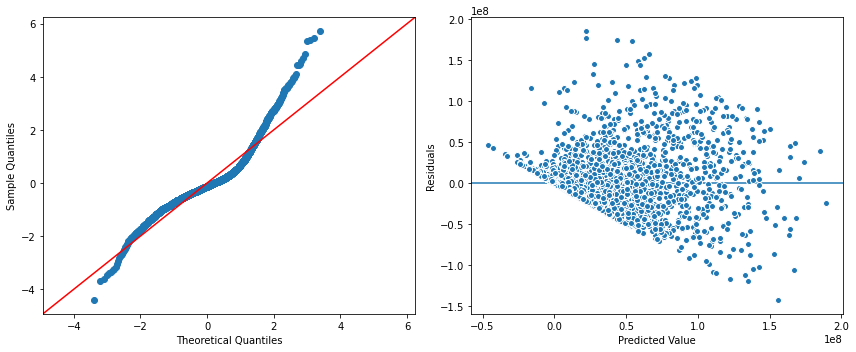

In [105]:
## make new df_final copy of prev df
df_final = df_clean_iqr.drop(columns =high_vif).copy()
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df_final)
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
evaluate_ols(result,X_train_df,y_train)

In [106]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.531
Testing R^2: 0.583


### Visualizing Coeffiicents

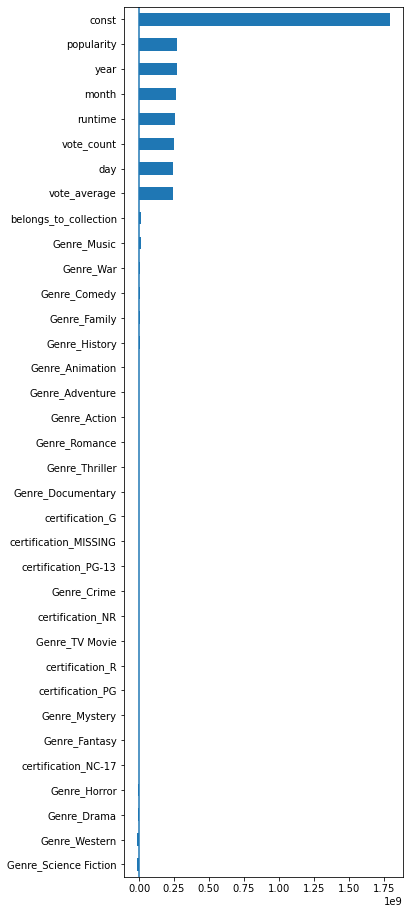

In [107]:
plt.figure(figsize=(5,16))
ax =result.params.sort_values().plot(kind='barh')
ax.axvline()

[Text(0.5, 1.0, '')]

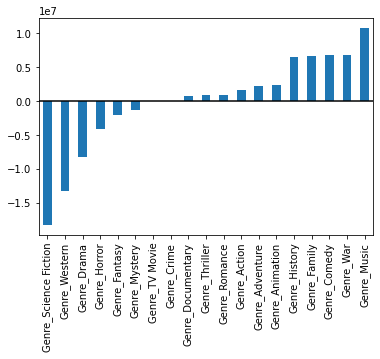

In [108]:
ax = result.params.loc[genre_cols].sort_values().plot(kind='bar')
ax.axhline(0,color='k')
ax.set(title='')

## Comparing Linear Reg to RandomForest

In [109]:
from sklearn.ensemble import RandomForestRegressor
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df)

reg = RandomForestRegressor(verbose=1,random_state=42)
reg.fit(X_train_df, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


RandomForestRegressor(random_state=42, verbose=1)

In [110]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = reg.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = reg.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.971
Testing R^2: 0.768


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


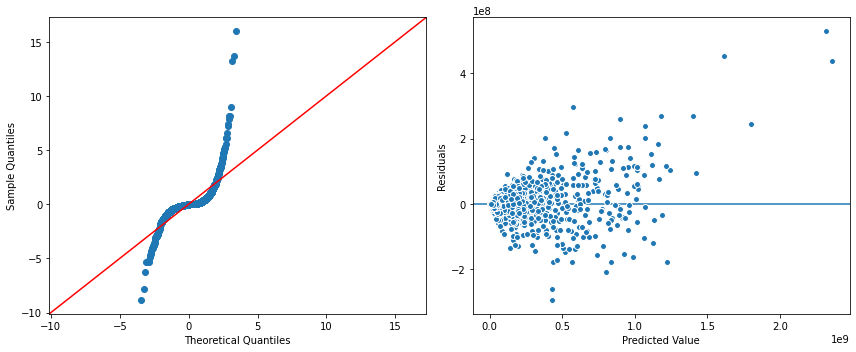

In [111]:
evaluate_ols(reg, X_train_df, y_train)

<AxesSubplot:>

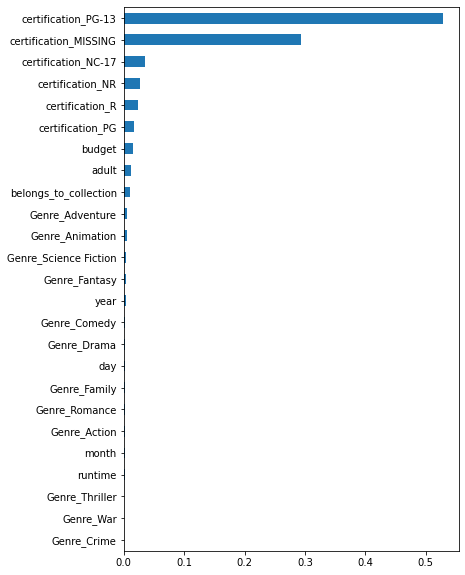

In [112]:
importances = pd.Series(reg.feature_importances_, index=X_train_df.columns)
importances.sort_values().tail(25).plot(kind='barh',figsize=(6,10))

# Summary

- Diagnosing linear regression models is an iterative process that can drive you mad if you let it. 

- Our final model is "good enough" for me to extract some business recommendations. 